Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5699 - loss: 0.8813 - val_accuracy: 0.7473 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7263 - loss: 0.6159 - val_accuracy: 0.7824 - val_loss: 0.4920 - learning_rate: 0.0010
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7675 - loss: 0.5148 - val_accuracy: 0.8144 - val_loss: 0.4187 - learning_rate: 0.0010
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7961 - loss: 0.4498 - val_accuracy: 0.8162 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8098 - loss: 0.4150 - val_accuracy: 0.8308 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8252 - loss: 0.3842 - val_accuracy: 0.8363 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8308 - loss: 0.373

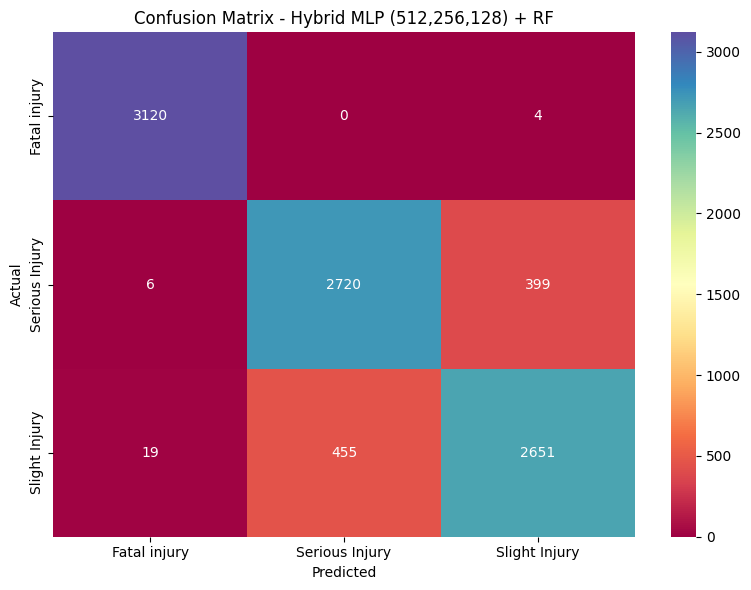

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load and clean dataset
df = pd.read_csv("RTA Dataset.csv")
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

df = df[selected_features + [target]]
for col in df.columns:
    df[col] = df[col].fillna('Unknown') if df[col].dtype == 'object' else df[col].fillna(df[col].mean())

label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop(target, axis=1)
y = df[target]

# Apply SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Scale for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encoding
num_classes = len(np.unique(y_train))
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# Build deeper MLP
inputs = Input(shape=(X_train_scaled.shape[1],))
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
penultimate = Dense(128, activation='relu', name='penultimate')(x)
outputs = Dense(num_classes, activation='softmax')(penultimate)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Train
model.fit(X_train_scaled, y_train_oh,
          epochs=50, batch_size=64, validation_split=0.15,
          callbacks=[early_stop, reduce_lr], verbose=1)

# Feature extraction
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('penultimate').output)
X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=400, max_depth=40, class_weight='balanced', random_state=42)
rf.fit(X_train_features, y_train)
y_pred = rf.predict(X_test_features)

# Evaluation
print("\nClassification Report (Enhanced Hybrid):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - Hybrid MLP (512,256,128) + RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


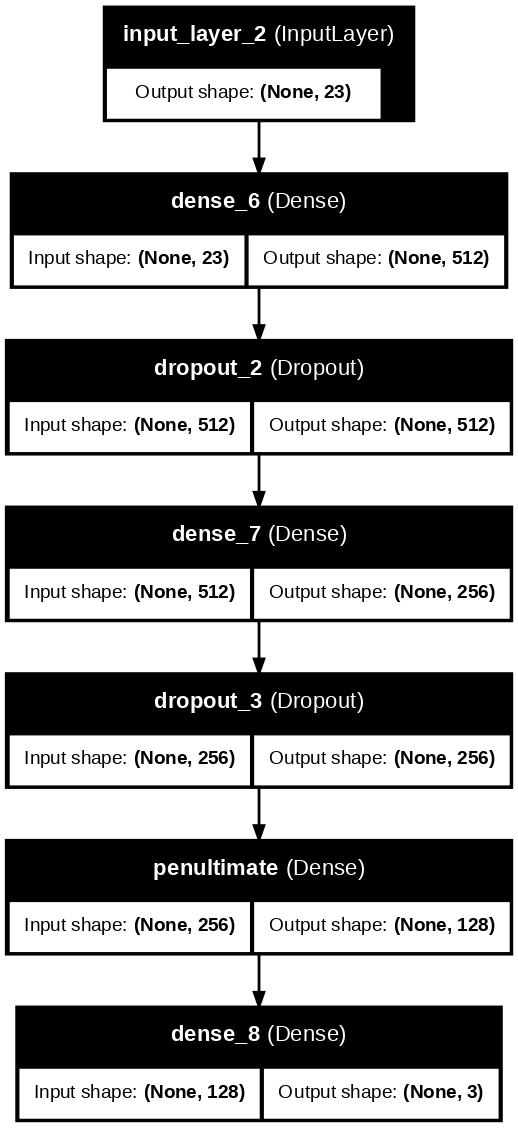

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, dpi=100, to_file='mlp_architecture.png')


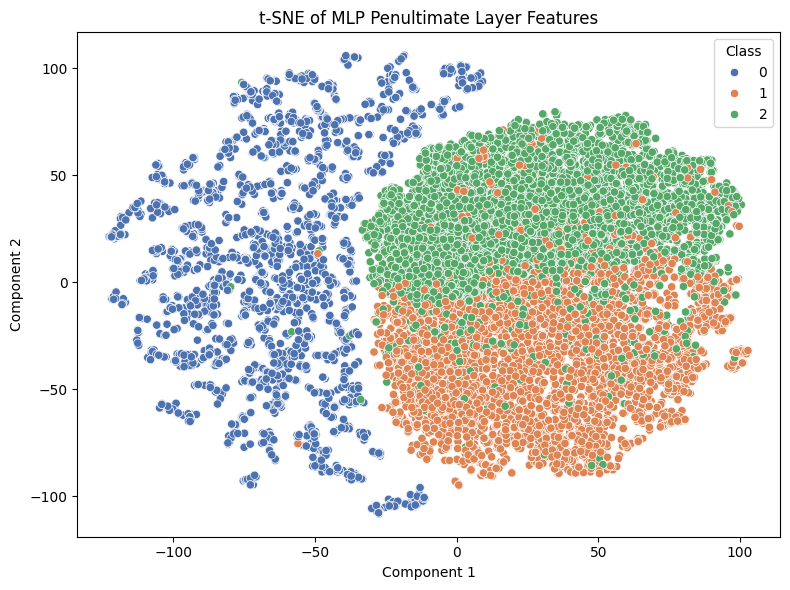

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns

# Use t-SNE on penultimate layer outputs
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train_features)  # from MLP.predict_proba or bottleneck

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_train, palette='deep')
plt.title("t-SNE of MLP Penultimate Layer Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


Epoch 1/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5597 - loss: 0.9066 - val_accuracy: 0.7345 - val_loss: 0.6281
Epoch 2/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7489 - loss: 0.5809 - val_accuracy: 0.7966 - val_loss: 0.4778
Epoch 3/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8124 - loss: 0.4323 - val_accuracy: 0.8304 - val_loss: 0.3946
Epoch 4/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8304 - loss: 0.3826 - val_accuracy: 0.8236 - val_loss: 0.3853
Epoch 5/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8479 - loss: 0.3445 - val_accuracy: 0.8323 - val_loss: 0.3661
Epoch 6/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8605 - loss: 0.3185 - val_accuracy: 0.8428 - val_loss: 0.3611
Epoch 7/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8669 - loss: 0.3019 - val_accuracy: 0.8551 - val_loss: 0.3395
Epoch 8/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8797 - loss: 0.2826 - val_accuracy: 0.

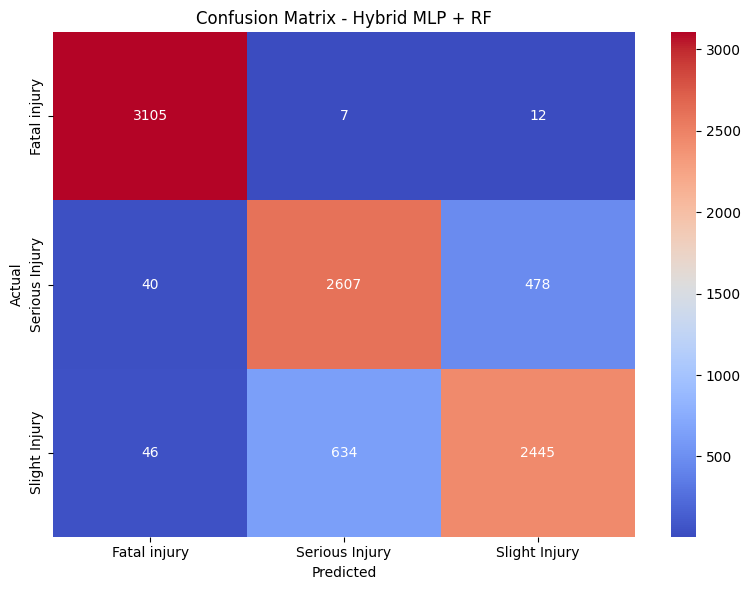

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv("RTA Dataset.csv")

# Selected features and target
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

# Subset and clean
df = df[selected_features + [target]]
for col in df.columns:
    df[col] = df[col].fillna('Unknown') if df[col].dtype == 'object' else df[col].fillna(df[col].mean())

# Label encoding
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop(target, axis=1)
y = df[target]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encoding for Keras
num_classes = len(np.unique(y_train))
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# Keras MLP model
inputs = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
penultimate = Dense(32, activation='relu', name='penultimate')(x)
outputs = Dense(num_classes, activation='softmax')(penultimate)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_scaled, y_train_oh, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

# Extract features from penultimate layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('penultimate').output)
X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)

# Train Random Forest on extracted features
rf = RandomForestClassifier(n_estimators=200, max_depth=30, class_weight='balanced', random_state=42)
rf.fit(X_train_features, y_train)
y_pred = rf.predict(X_test_features)

# Evaluation
print("\nClassification Report (Hybrid MLP + RF):")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - Hybrid MLP + RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Epoch 1/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5401 - loss: 0.9313 - val_accuracy: 0.7130 - val_loss: 0.6743
Epoch 2/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6833 - loss: 0.7106 - val_accuracy: 0.7701 - val_loss: 0.5417
Epoch 3/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7243 - loss: 0.6129 - val_accuracy: 0.7948 - val_loss: 0.4723
Epoch 4/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7519 - loss: 0.5499 - val_accuracy: 0.8126 - val_loss: 0.4272
Epoch 5/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7816 - loss: 0.4959 - val_accuracy: 0.8140 - val_loss: 0.4176
Epoch 6/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7848 - loss: 0.4766 - val_accuracy: 0.8332 - val_loss: 0.3941
Epoch 7/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7935 - loss: 0.4477 - val_accuracy: 0.8364 - val_loss: 0.3800
Epoch 8/30
308/308 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8003 - loss: 0.4400 - val_accuracy: 0.

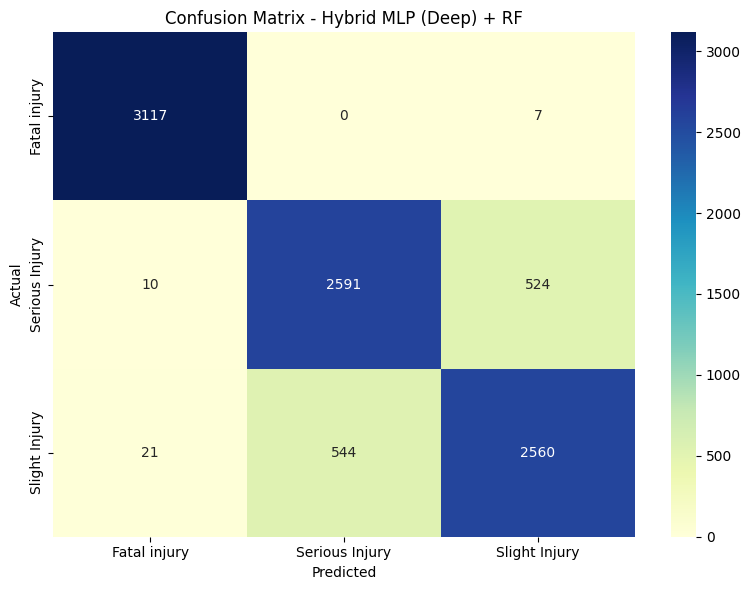

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Load and preprocess dataset
df = pd.read_csv("RTA Dataset.csv")

selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

df = df[selected_features + [target]]
for col in df.columns:
    df[col] = df[col].fillna('Unknown') if df[col].dtype == 'object' else df[col].fillna(df[col].mean())

label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

X = df.drop(target, axis=1)
y = df[target]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split & scale
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot for Keras
num_classes = len(np.unique(y_train))
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# Build deeper Keras MLP
inputs = Input(shape=(X_train_scaled.shape[1],))
x = Dense(256, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
penultimate = Dense(64, activation='relu', name='penultimate')(x)
outputs = Dense(num_classes, activation='softmax')(penultimate)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
model.fit(X_train_scaled, y_train_oh,
          epochs=30, batch_size=64, validation_split=0.1,
          verbose=1, callbacks=[early_stop])

# Extract penultimate layer features
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('penultimate').output)
X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)

# Train Random Forest on embeddings
rf = RandomForestClassifier(n_estimators=300, max_depth=20, class_weight='balanced', random_state=42)
rf.fit(X_train_features, y_train)
y_pred = rf.predict(X_test_features)

# Evaluation
print("\nClassification Report (Improved Hybrid):")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - Hybrid MLP (Deep) + RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
